In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Exercise: Use a Double Dueling DQN to train an agent that can achieve a superhuman level at the famous Atari Breakout game ("ALE/Breakout-v5"). The observations are images. To simplify the task, you should convert them to grayscale (i.e., average over the channels axis), crop them and downsample them, so they're just large enough to play, but not much more. An individual image does not tell you which way the ball and the paddles are going, so you should merge two or three consecutive images to form each state. Lastly, the DQN should be composed mostly of convolutional layers.

TODO

Check out the State-of-the-Art for Atari Games on paperswithcode.com.

10.
Exercise: If you have about $100 to spare, you can purchase a Raspberry Pi 3 plus some cheap robotics components, install TensorFlow on the Pi, and go wild! For an example, check out this fun post by Lukas Biewald, or take a look at GoPiGo or BrickPi. Start with simple goals, like making the robot turn around to find the brightest angle (if it has a light sensor) or the closest object (if it has a sonar sensor), and move in that direction. Then you can start using Deep Learning: for example, if the robot has a camera, you can try to implement an object detection algorithm so it detects people and moves toward them. You can also try to use RL to make the agent learn on its own how to use the motors to achieve that goal. Have fun!

It's your turn now: go crazy, be creative, but most of all, be patient and move forward step by step, you can do it!

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [1]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array") 

ModuleNotFoundError: No module named 'gymnasium'

In [17]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

In [18]:
#gym.envs.registry.all()

In [19]:
# extra code – shows the specification for the CartPole-v1 environment
#print(envs)
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [20]:
 observation, info = env.reset(seed=42)
 observation
param = [' horizontal position', 'velocity', 'angle', 'angular velocity']
for i in range(len(observation)):
    print(i,param[i], observation[i])

0  horizontal position 0.027395604
1 velocity -0.006112156
2 angle 0.035859793
3 angular velocity 0.019736802


In [21]:
info

{}

In [22]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

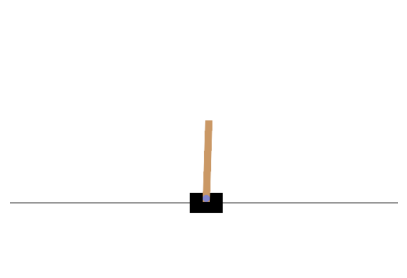

In [14]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()


In [15]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

C:\Users\Emakam leumassa\AppData\Local\Programs\Python\Python310\Lib\site-packages\gymnasium

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [23]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [24]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)


Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

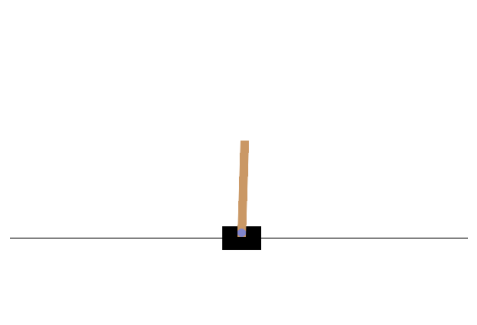

In [25]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [26]:
reward

1.0

In [2]:
3**2

27

When the game is over, the environment returns done=True. In this case, it's not over yet:

In [27]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, truncated will be set to True. In this case, it's not truncated yet:

In [28]:
truncated

False

Finally, info is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [29]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when step() returns done=True or truncated=True), you should reset the environment before you continue to use it.

In [30]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and vice versa. Let's see if that works:

In [31]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [32]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the Matplotlib tutorial notebook.

In [33]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

In [28]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [29]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

# Policy Gradients

o train this neural network we will need to define the target probabilities y. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the credit assignment problem.

The Policy Gradients algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [30]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If left_proba is high, then action will most likely be False (since a random number uniformally sampled between 0 and 1 will probably not be greater than left_proba). And False means 0 when you cast it to a number, so y_target would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the play_one_step() function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [32]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [33]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [34]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [35]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [36]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [37]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [38]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [39]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 160.8

In [40]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

# Extra Material – Markov Chains

The following transition probabilities correspond to the Markov Chain represented in Figure 18–7. Let's run this stochastic process a few times to see what it looks like:

In [57]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3
print(len(transition_probabilities))
n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

4
Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


# Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are [0.7, 0.3, 0.0], and the rewards are [+10, 0, 0]):

In [58]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

In [66]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [67]:
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

In [68]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [64]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1], dtype=int64)

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2. If you try again with a discount factor of 0.95 instead of 0.90, you will find that the optimal action for state s1 becomes a2. This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

In [65]:
Q_values = np.full((3, 3), -np.inf)
print(Q_values)

[[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]


# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [69]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [70]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [71]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [72]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

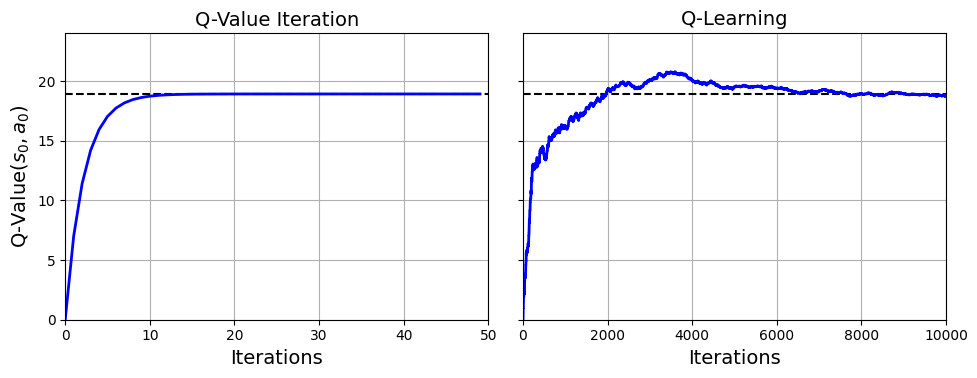

In [73]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

# Deep Q-Network
Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [82]:
 tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability epsilon.

In [75]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

We will also need a replay buffer. It will contain the agent's experiences, in the form of tuples: (obs, action, reward, next_obs, done). We can use the deque class for that:

In [76]:
from collections import deque

replay_buffer = deque(maxlen=2000)

Note: for very large replay buffers, you may want to use a circular buffer instead, as random access time will be O(1) instead of O(N). Or you can check out DeepMind's Reverb library.

In [77]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    
    
    
    class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.size = 0
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        #batch = np.random.choice(self.buffer, batch_size) #, replace=False)
        batch = self.buffer[indices]
        state, action, reward, next_state, done = zip(*batch)
        return np.stack(state), action, reward, np.stack(next_state), done

And let's create a function to sample experiences from the replay buffer. It will return 6 NumPy arrays: [obs, actions, rewards, next_obs, dones, truncateds]

In [78]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

Now we can create a function that will use the DQN to play one step, and record its experience in the replay buffer:

In [79]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Lastly, let's create a function that will sample some experiences from the replay buffer and perform a training step:

In [83]:
# extra code – for reproducibility, and to generate the next figure

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [84]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 494, Steps: 200, eps: 0.014

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
#from time2vec import Time2Vec
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')


import warnings
warnings.filterwarnings('ignore')


class Time2Vector(Layer):
      def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

      def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

      def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

      def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

class PositionalEncoding(Layer):
    def __init__(self, max_seq_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = self._get_positional_encoding()

    def _get_positional_encoding(self):
        position = np.arange(self.max_seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        sin_term = np.sin(position * div_term)
        cos_term = np.cos(position * div_term)
        encoding = np.concatenate([sin_term, cos_term], axis=-1)
        encoding = encoding[np.newaxis, ...]
        return tf.cast(encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.encoding[:, :tf.shape(inputs)[1], :17]
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'max_seq_len': self.max_seq_len,
            'd_model': self.d_model
        })
        return config



class SingleAttention_longterm(Layer):
  def __init__(self, d_k, d_v, filters = 9, kernel_size = 16):
    super(SingleAttention_longterm, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.filters = filters 
    self.kernel_size = kernel_size

  def build(self, input_shape):
    pad_len = self.kernel_size // 2
    self.query = Conv1D(self.filters, self.kernel_size, activation='tanh', padding='valid', input_shape=input_shape)
    
    self.key = Conv1D(self.filters, self.kernel_size, activation='tanh', padding='valid', input_shape=input_shape)
    
    self.value = Conv1D(self.filters, self.kernel_size, activation='tanh', padding='valid', input_shape=input_shape)
    
    self.wq = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    
    self.wk = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.wv = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
       
    #self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    
    #self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
  def call(self, inputs, mask): # inputs = (in_seq, in_seq, in_seq)
    c_q = self.query(inputs[0])
    
    c_k = self.key(inputs[1])
    
    c_v = self.value(inputs[2])
    
    pad_len = self.kernel_size // 2
    c_q = tf.pad(c_q, [[0,0], [pad_len, pad_len], [0,0]], "CONSTANT")
    c_k = tf.pad(c_k, [[0,0], [pad_len, pad_len], [0,0]], "CONSTANT")
    c_v = tf.pad(c_v, [[0,0], [pad_len, pad_len], [0,0]], "CONSTANT")
    
    q = self.wq(c_q[:,:64,:])
    
    k = self.wk(c_k[:,:64,:])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    if mask is not None:
        mask = tf.cast(mask, tf.float32)
        attn_weights += (mask * -1e10)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.wv(c_v[:,:64,:]) 
    
    attn_out = tf.matmul(attn_weights, v)
    
    # perform padding to restore the original shape
    
    return attn_out

class SingleAttention_shortterm(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention_shortterm, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    

  def call(self, inputs, mask): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])
    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    if mask is not None:
        mask = tf.cast(mask, tf.float32)
        attn_weights += (mask * -1e10)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads, dropout = 0.1):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    for n in range(self.n_heads):
        if n%2 == 0:
            self.attn_heads.append(SingleAttention_longterm(self.d_k, self.d_v)) 
        else:
            self.attn_heads.append(SingleAttention_shortterm(self.d_k, self.d_v)) 
            
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-9) #6

    self.cnn = Conv2D(filters=1, kernel_size=(3, 3), padding='same')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')
    
    
  def call(self, inputs, mask):
    attn = [self.attn_heads[i](inputs, mask) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)    
    #cnn_input = tf.expand_dims(inputs[0], axis=-1)  # Add a new dimension at the end
    #cnn_output = self.cnn(cnn_input)
    #cnn_output = tf.squeeze(cnn_output, axis=-1)  # Remove the last dimension
    #gate = tf.keras.activations.sigmoid(cnn_output
    multi_linear = self.attn_dropout(multi_linear)
    multi_linear = multi_linear 
    return multi_linear          #tf.multiply(multi_linear, cnn_output)


#############################################################################
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout
       
    
    def build(self, input_shape):
        
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        
        
        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=3, padding='same', activation='tanh')
        self.ff_conv1D_2 = Conv1D(filters=19, kernel_size=1, padding='same', activation='linear') #9 # New layer
       
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-9)

        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-9)    
        
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')
        
        self.cnn = Conv1D(filters=self.ff_dim, kernel_size=3, padding='same', activation='linear')
        #self.rnn = LSTM(7, return_sequences=True)
   
    def call(self, inputs, mask = None): # inputs = (in_seq, in_seq, in_seq)
        
        
        attn_layer = self.attn_multi(inputs, mask)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        cnn_layer = self.cnn(attn_layer)
        cnn_layer = self.ff_conv1D_1(cnn_layer) # Pass through the new layer
        cnn_layer = self.ff_conv1D_2(cnn_layer)
  
        ff_layer = self.linear(attn_layer)
        ff_layer = tf.keras.activations.sigmoid(ff_layer)
        ff_layer = cnn_layer * ff_layer
        ff_layer = self.ff_dropout(ff_layer)
        attn_layer = self.attn_normalize(attn_layer + ff_layer)

        return  attn_layer
 
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config   
    
    
class TransformerDecoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerDecoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_heads = list()

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        
        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=3, padding='same', activation='tanh')
        self.ff_conv1D_2 = Conv1D(filters=19, kernel_size=1, padding='same', activation='linear') #9
        
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(epsilon=1e-6)

        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(epsilon=1e-6)

        self.linear = Dense(input_shape[0][-1], kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.cnn = Conv1D(filters=self.ff_dim, kernel_size=3, padding='same', activation='linear')

    def call(self, inputs, encoder_output, padding_mask = None, look_front_mask = None):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs, padding_mask)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(attn_layer + inputs[0])
        #cnn_layer = self.cnn(attn_layer)
        #cnn_layer = self.ff_conv1D_1(cnn_layer)
        #cnn_layer = self.ff_conv1D_2(cnn_layer)

        #ff_layer = self.linear(attn_layer)
        #ff_layer = tf.keras.activations.sigmoid(ff_layer)
        #ff_layer = cnn_layer * ff_layer
        #ff_layer = self.ff_dropout(ff_layer)
        #attn_layer = self.ff_normalize(ff_layer + attn_layer)
        # Apply encoder-decoder attention
        #encoder_attn_layer = tf.concat([encoder_output[0], attn_layer], axis=1)
        
        encoder_attn_layer = self.attn_multi((attn_layer, encoder_output[0], encoder_output[0]), look_front_mask)
        encoder_attn_layer = self.attn_dropout(encoder_attn_layer)
        encoder_attn_layer = self.attn_normalize(encoder_attn_layer + attn_layer)

        cnn_layer = self.cnn(encoder_attn_layer)
        cnn_layer = self.ff_conv1D_1(cnn_layer)
        cnn_layer = self.ff_conv1D_2(cnn_layer)

        ff_layer = self.linear(encoder_attn_layer)
        ff_layer = tf.keras.activations.sigmoid(ff_layer)
        ff_layer = cnn_layer * ff_layer
        ff_layer = self.ff_dropout(ff_layer)
        encoder_attn_layer = self.ff_normalize(ff_layer + encoder_attn_layer)
       
        return encoder_attn_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'dropout_rate': self.dropout_rate})
        return config


class TransformerPolicy(Model):
    
    def __init__(self, d_k, d_v, n_heads, ff_dim, action_space = None, observation_space = None):
        super(TransformerModel, self).__init__()
        # Define your transformer layers and other components here
        self.time_embedding = Time2Vector(seq_len = 64) 
        self.positional_encoding = PositionalEncoding(max_seq_len=64, d_model=d_k)
        self.encoder = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.decoder = TransformerDecoder(d_k, d_v, n_heads, ff_dim)
        self.act = Dense(action_space, activation='softmax')
        self.dense = Dense(64, activation='relu') 
        
    def call(self, observations, attention_mask = None): 
        # Implement your forward pass logic here using the transformer layers and components
        x = self.positional_encoding(observations)
        x = self.time_embedding(x)
        x0 = Concatenate(axis=-1)([observations, x]) #this concatenate sequence of 128 value of x
        padding_mask = tf.cast(tf.math.equal(tf.reduce_sum(x0, axis=-1), 0), tf.float32)
        padding_mask = tf.expand_dims(padding_mask, axis=2)  # Add an extra dimension
        lookahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) 
        encoded_states = self.encoder((x0,x0,x0), padding_mask)
        decoded_states = self.decoder(encoded_states, (x0,x0,x0), padding_mask, lookahead_mask)
        x = GlobalAveragePooling1D(data_format='channels_first')(decoded_states)
        x = Dropout(0.1)(x) 
        x = self.dense(x)  
        action_preds = self.act(x)
        return action_preds

    
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(self.buffer, batch_size, replace=False)
        state, action, reward, next_state, done = zip(*batch)
        return np.stack(state), action, reward, np.stack(next_state), done

    def __len__(self):
        return len(self.buffer)


class DQN:
    def __init__(
        self,
        env_name,
        hidden_size=128,
        n_heads=4,
        d_k = 64,
        d_v = 64,
        ff_dim = 32,
        num_layers=2,
        replay_capacity=10000,
        batch_size=64,
        learning_rate=0.001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.001,
        target_update=10,
    ):
        self.env = gym.make(env_name)
        self.hidden_size = hidden_size
        self.n_heads= n_heads
        self.d_k = d_k
        self.d_v = d_v
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.replay_buffer = ReplayBuffer(replay_capacity)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        self.policy_net = TransformerPolicy(self.d_k, self.d_v, self.n_heads, self.ff_dim, len(env.action_space))
        self.target_net = TransformerPolicy(self.d_k, self.d_v, self.n_heads, self.ff_dim, len(env.action_space))
        
        self.target_net.set_weights(self.policy_net.get_weights())

        self.optimizer = Adam(learning_rate)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

        self.steps_done = 0

    def select_action(self, state):
        sample = np.random.random()
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(
            -self.epsilon_decay * self.steps_done
        )
        self.steps_done += 1
        if sample > epsilon:
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            state = tf.expand_dims(state, axis=0)
            q_values = self.policy_net(state)
            action = tf.argmax(q_values, axis=1).numpy()[0]
        else:
            action = self.env.action_space.sample()
        return action

    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size
        )
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        with tf.GradientTape() as tape:
            q_values = self.policy_net(states)
            q_values = tf.gather(q_values, actions, batch_dims=1)
            next_q_values = self.target_net(next_states)
            next_q_values = tf.reduce_max(next_q_values, axis=1)
            expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

            loss = self.loss_fn(q_values, expected_q_values)

        grads = tape.gradient(loss, self.policy_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_net.trainable_variables))

    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.replay_buffer.push(state, action, reward, next_state, done)
                total_reward += reward

                state = next_state
                self.optimize_model()

                if done:
                    break

            if episode % self.target_update == 0:
                self.target_net.set_weights(self.policy_net.get_weights())

            print(f"Episode: {episode}, Reward: {total_reward}")

    def test(self):
        state = self.env.reset()
        total_reward = 0

        while True:
            self.env.render()
            action = self.select_action(state)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward

            if done:
                break

        self.env.close()
        print(f"Test Reward: {total_reward}")


# Usage example
dqn = DQN(env_name="CartPole-v1")
dqn.train(num_episodes=100)
dqn.test()






    
    
    
    
    
    
 


In [ ]:
model1 = DQN("MlpPolicy", env, verbose=1, gamma = 0.1, batch_size = 8192, learning_rate = 0.000000001)

In [36]:
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from functions import click, webdriver, show_me, get, find
import time
import numpy as np

url = 'https://in.tradingview.com/chart/kJDanB6j/?symbol=FX%3AEURUSD'  # enter your trading view profile link here.
min_value = 0  # enter your minimum stop loss value.
max_value = 10  # enter your maximum stop loss value.
increment = .1  # You can increment count in decimals or in whole numbers.
range = np.arange(min_value, max_value, increment)


def run_script(driver):
    """find the best stop loss value."""
    wait = WebDriverWait(driver, 5)
    driver.get(url)

    click.strategy_tester()
    try:
        click.overview()
    except NoSuchElementException:
        time.sleep(1)
        click.overview()

    print("Generating Max Profit For Stop Loss.\n")
    print("Loading script...")
    for number in range:
        count = round(number, 2)
        try:
            click.settings_button(wait)
            click.stoploss_input(count, wait)  # clicking stop loss input text box and entering number.
            get.net_value(count, wait)

        except (StaleElementReferenceException, TimeoutException, NoSuchElementException):
            print("script has timed out.")
            break

    # adding the new value to your strategy.
    click.settings_button(wait)
    best_key = find.best_key()
    click.stoploss_input(best_key, wait)
    time.sleep(.5)

    print("\n----------Results----------\n")
    click.overview()
    show_me.best_stoploss()
    click.performance_summary()
    show_me.total_closed_trades()
    show_me.win_rate()
    show_me.net_profit()
    show_me.max_drawdown()
    show_me.sharpe_ratio()
    show_me.win_loss_ratio()
    show_me.avg_win_trade()
    show_me.avg_loss_trade()
    show_me.avg_bars_in_winning_trades()
    # show_me.gross_profit()
    # show_me.gross_loss()
    # show_me.buy_and_hold_return()
    # show_me.max_contracts_held()
    # show_me.open_pl()
    # show_me.commission_paid()
    # show_me.total_open_trades()
    # show_me.number_winning_trades()
    # show_me.number_losing_trades()
    # show_me.percent_profitable()
    # show_me.avg_trade()
    # show_me.largest_win_trade()
    # show_me.largest_loss_trade()
    # show_me.avg_bars_in_trades()
    # show_me.avg_bars_in_losing_trades()


if __name__ == '__main__':
    run_script(webdriver.driver)


SyntaxError: invalid syntax (functions.py, line 68)

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1


In [ ]:
class Actions(Enum):
    Sell = 0
    Buy = 1
    #Rest = 2

class Positions(Enum):
    Short = 0 #on sell position
    Long = 1  #on buy position
    #Rest = 2
    def opposite(self):
        k = np.random.randint(2)
        if k == 0:
            return  Positions.Short
        if k == 1:
            return Positions.Long
        
        #return Positions.Short if self == Positions.Long else Positions.Long
    #def rest(self):
        #return Positions.Rest
    
class Customtradingenv(Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size, frame_bound, unit_side='right'):
        
        assert df.ndim == 2
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']
        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        #self.action_space = spaces.Discrete(len(Actions))
        #self.action_space = spaces.box.Box(low=0, high=1, shape=(1,1) , dtype=np.float32)
        #self.action_space = Tuple((Box(low=0, high=2, shape=self.shape, dtype=np.float64), Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)))\n",
        #########################################################\n",
        self.action_space = Discrete(len(Actions)+5)      
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

        self.trade_fee = 0.0003  # unit
        
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


        # self.custom = .
    def step(self, action):
        self._done = False 
        
        
        self._current_tick += 1
        
        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
                  trade = True
        
        
        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick
        #if self._calculate_reward(action) == 0:
         #    self._position = self._position.rest()
                

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


        #check if shower is done
    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
           # elif position ==  Positions.Rest:
              #  color = 'blue'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
       # rest_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
            #elif self._position_history[i] == Positions.Rest:
               # rest_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'rv')
        plt.plot(long_ticks, self.prices[long_ticks], 'g^')
        #plt.plot(rest_ticks, self.prices[rest_ticks], 'b^' )

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        pass
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)
        
    def pause_rendering(self):
        plt.show()

    
    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]
        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))
        
        
        
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = self.df.loc[:, ['EMAF', 'EMAM', 'EMAS', 'slopeEMAF', 'slopeEMAM', 'slopeEMAS', 'slopeATR', 'slopeEMASS', 'signal', 'ATR', 'RSI']].to_numpy()[start:end]


        
        return prices, signal_features


    def _calculate_reward(self, action):
            step_reward = 0  # pip\n",
            reward_scale = 100
            safety_buffer = 0.6
            action = int(action)
            #print(action)\n",
            #if action == Actions.Rest.value:\n",
             #   print('2')\n",
             #   return step_reward\n",
            trade =  False
            if ((action >= Actions.Buy.value and self._position == Positions.Short) or #567
                (action <= Actions.Sell.value and self._position == Positions.Long)):  #123
                trade = True
            if trade:     
                     current_price = self.prices[self._current_tick]
                     last_trade_price = self.prices[self._last_trade_tick]
                     self.price_diff = current_price - last_trade_price
                    
                     if self._position == Positions.Short: #meaning on the sell postion but we don't if the trend is up or down \n",
                               step_reward += -self.price_diff * reward_scale 
                            # Increase reward for larger profits\n",
                               if -self.price_diff > 0: 
                                    step_reward += -(self.price_diff**2) * reward_scale * safety_buffer 
                            # Reduce reward for small losses\n",
                               elif  -self.price_diff < 0:
                                    step_reward -= abs(-(self.price_diff**2)) * reward_scale * safety_buffer
                                    print('1')
                                    
                    
                     elif self._position == Positions.Long:
                              step_reward += self.price_diff * reward_scale

                              if self.price_diff > 0:
                                        step_reward += (self.price_diff**2) * reward_scale * safety_buffer
                              elif self.price_diff < 0:
                                        step_reward -= abs(self.price_diff**2) * reward_scale * safety_buffer
                                        print('0')
               
            return step_reward
                
       # if action ==  Actions.Rest.value and self.price_diff * 10000 == 0:
        #    semi = 1

        #if semi == 1:
        #    if self.price_diff == 0:
         #       print('rest')
          #      return 0
                
           
        #return step_reward


    def _update_profit(self, action):
        trade = False
        
        
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
              trade = True
                
       
        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit



In [8]:
1.3**2 -1

0.6900000000000002